# Assignment 3 (100 marks)

## *Generating useful features for further analysis on Amazon reviews*

## Introduction

**Business Context.** You are a business consultant with new clients that are interested in analyzing reviews of their products on Amazon (as opposed to Yelp). They want to answer business questions like: "What are the most important factors driving negative reviews?", "Have there been any large changes to customer satisfaction/reviews over time?", etc.

**Business Problem.** Your main task is to **explore the given data and use the results of your investigation to engineer relevant features that could facilitate subsequent analysis and model-building**.

**Analytical Context.** The dataset provided is a large body of reviews related to movies and television left on Amazon between 1996 and 2014. When exploring our dataset, we will quickly encounter a familiar problem we discussed in the previous case: the word "good" is one of the most important words in both positive *and* negative reviews. Thus, we must develop methods to put "good" in the appropriate context.

## Loading the data

We use a dataset of around 37,000 video reviews from Amazon Instant Video and 1,700,000 movie and TV reviews, all obtained from the website: http://jmcauley.ucsd.edu/data/amazon/. Note that there are much larger datasets available at the same site. We can expect better and more consistent results on larger datasets (such as book reviews). Note that these datasets are compressed (gzipped), and they are in [JSON](https://en.wikipedia.org/wiki/JSON) format, with each line representing a review and each line being its own JSON object.

We begin by loading the dataset below:

In [196]:
# !pip install pingouin

In [197]:
# pip install wordcloud

In [198]:
%%time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats 
from pingouin import pairwise_tests #this is for performing the pairwise tests
from pingouin import pairwise_ttests #this is for performing the pairwise tests
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import nltk
import gzip
import json
import string
import nltk # imports the natural language toolkit
import plotly
from nltk.corpus import stopwords
%matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')

# We won't use this one this time
# we can tell pandas that our file is in gzip format and it will handle the decompression for us
# we also use `lines=True` to indicate that each line of the file is its own JSON object
# instant_video = pd.read_json("reviews_Amazon_Instant_Video_5.json.gz", lines=True, compression='gzip')


# ----------
# The Movies and TV file is very big. If you have problems loading it, you can load only the first 
# 100,000 reviews by using 'chunksize' (uncomment the line with 'chunksize' and comment out the line 
# after that which loads the entire file into `movies_tv`). All of the analysis can be 
# done in the same way using only the subset of reviews but some of the results might be different from the examples.
# ----------
# movies_tv = next(pd.read_json("data/reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip', chunksize=100000))
movies_tv = pd.read_json("data/reviews_Movies_and_TV_5.json.gz", lines=True, compression='gzip')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fabie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: total: 46.4 s
Wall time: 1min 49s


In [199]:
# This is just because my code is not being colour coded even though it still works properly.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats 
from pingouin import pairwise_tests #this is for performing the pairwise tests
from pingouin import pairwise_ttests #this is for performing the pairwise tests
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime
import nltk
import gzip
import json
import string
import nltk # imports the natural language toolkit
import plotly
from nltk.corpus import stopwords
%matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fabie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Examining the data

We take a look at the first 5 rows of each dataset to see what attributes are available. These are

* **reviewerID:** A unique ID to identify the author of the review.
* **asin:** The ["Amazon Standard Identification Number"](https://www.amazon.com/gp/seller/asin-upc-isbn-info.html) which provides more information about the exact product and version.
* **reviewerName:** The username chosen by the reviewer.
* **helpful:** A record of how many users indicated that the review was helpful/not helpful.
* **reviewText:** The full text of the review.
* **overall:** The overall rating (1-5) left by the reviewer.
* **summary:** A short version of the review, used as the title.
* **unixReviewTime:** The date that the review was created, in [Unix Epoch](https://en.wikipedia.org/wiki/Unix_time) format.
* **reviewTime:** A human readable date giving the day, month, and year.
</font>

In [200]:
print(len(movies_tv))
print(movies_tv.head(5))
movies_tv.shape

1697533
       reviewerID        asin                         reviewerName helpful  \
0   ADZPIG9QOCDG5  0005019281  Alice L. Larson "alice-loves-books"  [0, 0]   
1  A35947ZP82G7JH  0005019281                        Amarah Strack  [0, 0]   
2  A3UORV8A9D5L2E  0005019281                      Amazon Customer  [0, 0]   
3  A1VKW06X1O2X7V  0005019281           Amazon Customer "Softmill"  [0, 0]   
4  A3R27T4HADWFFJ  0005019281                                 BABE  [0, 0]   

                                          reviewText  overall  \
0  This is a charming version of the classic Dick...        4   
1  It was good but not as emotionally moving as t...        3   
2  Don't get me wrong, Winkler is a wonderful cha...        3   
3  Henry Winkler is very good in this twist on th...        5   
4  This is one of the best Scrooge movies out.  H...        4   

                                        summary  unixReviewTime   reviewTime  
0                     good version of a classic      

(1697533, 9)

We notice that `movies_tv` is extremely long with nearly 2 million reviews, and several columns seem uninteresting or hard to work with (e.g. `reviewerID`, `asin`, `reviewername`, `reviewtime`). We drop some information to make some of our later analysis more efficient. We also add a datetime column with Python datetime objects to more easily summarize the data:

In [201]:
movies_tv['datetime'] = pd.to_datetime(movies_tv['reviewTime'], format="%m %d, %Y")

In [202]:
movies_tv = movies_tv.drop(columns = ['reviewerID', 'asin', 'reviewerName', 'reviewTime'])

movies_tv.head(5)

,helpful,reviewText,overall,summary,unixReviewTime,datetime
0,"[0, 0]",This is a charming version of the classic Dick...,4,good version of a classic,1203984000,2008-02-26
1,"[0, 0]",It was good but not as emotionally moving as t...,3,Good but not as moving,1388361600,2013-12-30
2,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3,Winkler's Performance was ok at best!,1388361600,2013-12-30
3,"[0, 0]",Henry Winkler is very good in this twist on th...,5,It's an enjoyable twist on the classic story,1202860800,2008-02-13
4,"[0, 0]",This is one of the best Scrooge movies out. H...,4,Best Scrooge yet,1387670400,2013-12-22


### Exercise 1 (22 marks): 

#### 1.1 (4 marks)

Plot histograms of all numeric quantities for the `movies_tv` DataFrame. Note any observations (a few bullet points is fine). 

**Answer.**

In [203]:
movies_tv['year'] = movies_tv['datetime'].dt.year

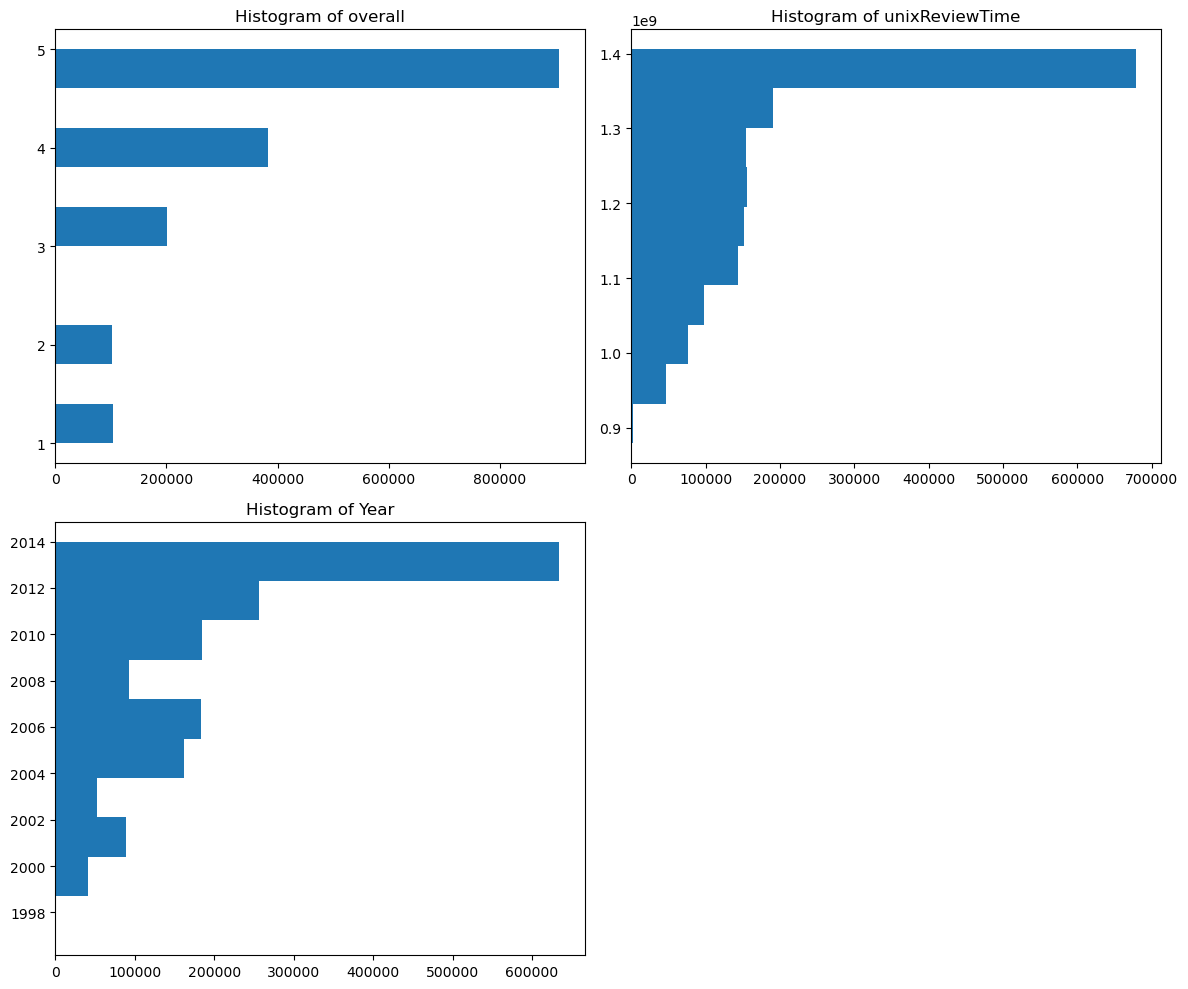

In [204]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.title('Histogram of overall')
plt.hist(data = movies_tv, x = 'overall', orientation='horizontal')
plt.yticks(range(1, 6, 1))

plt.subplot(2,2,2)
plt.title('Histogram of unixReviewTime')
plt.hist(data = movies_tv, x = 'unixReviewTime', orientation='horizontal', bins=10)

plt.subplot(2,2,3)
plt.title('Histogram of Year')
plt.hist(data=movies_tv, x = 'year', orientation='horizontal', bins=10) #datetime instead of year
plt.yticks(range(1998, 2016, 2))

plt.tight_layout()


#### 1.2 (4 marks)

How do average ratings change over time in the `movies_tv` DataFrame? Plot the average rating for each year and note any trends (a few bullet points is fine). 

Overall Rating Plot
- There are a lot more positive reviews than negative reviews. The plot mainly consists of 3, 4, and 5 overall ratings with very little 1 and 2 overall ratings. 

Unix Review Time Plot
- We see that the frequency increases as the unix time value increases. Higher value unix time indicates more recent time whereas lower value unix time indicates an older time. Here, we see that we have the most frequency within the interval 1.35-1.40 which is the maxmimum value in our range. This means a lot of our reviews are more recent.

Year 
- Similarly to the Unix Review analysis, the frequency increases as the years increase. This is because year expresses unix time in a different way, hence, it makes sense that their graphs are identical. The only reason why they might not look 100% identical in the plots is due to the interval which the axes increase.

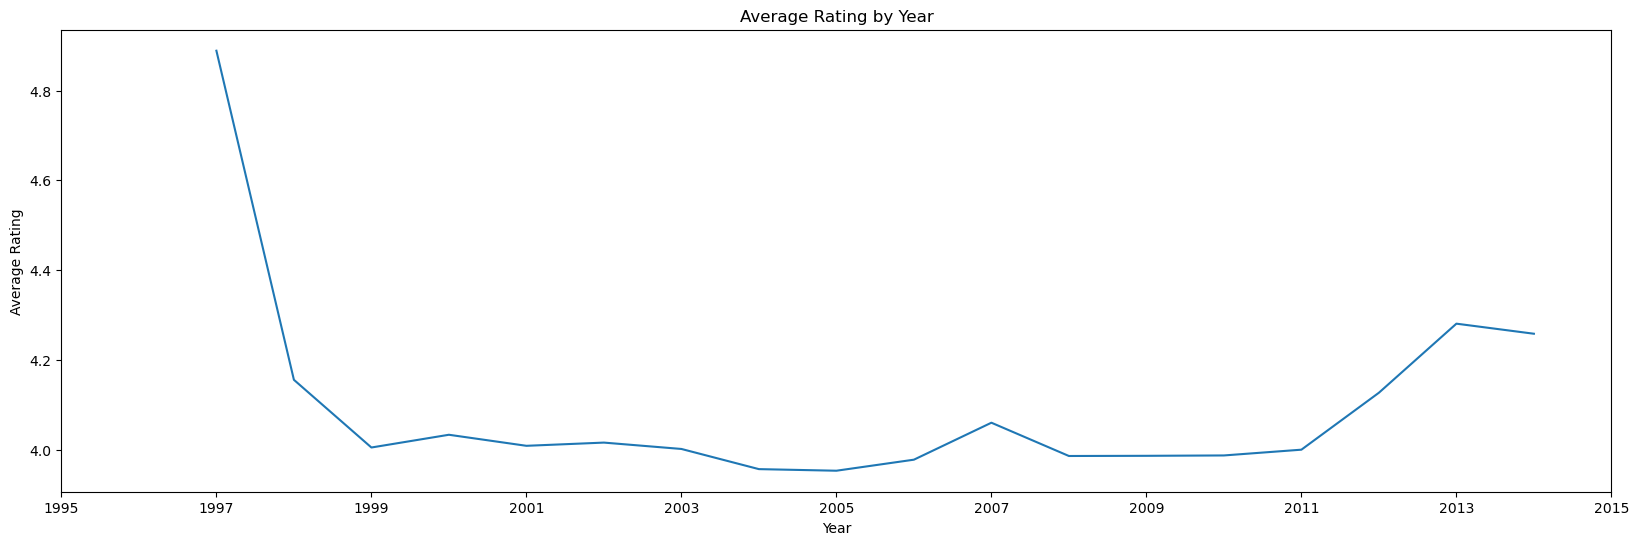

In [205]:
avg_rating_by_year = movies_tv.groupby(movies_tv['year'])['overall'].mean().reset_index()
avg_rating_by_year

sns.lineplot(x = avg_rating_by_year['year'], y = avg_rating_by_year['overall'])
plt.title('Average Rating by Year')
plt.xlabel('Year')
plt.ylabel('Average Rating')   
plt.xticks(ticks=range(1995, 2016, 2))
plt.show()
# avg_rating_by_year['datetime'].describe() #Min is 1997, Max is 2014

In [206]:
avg_rating_by_year[avg_rating_by_year['overall'] == avg_rating_by_year['overall'].min()]

,year,overall
8,2005,3.953155


The average ratings were at an all time high in 1997 and all time low in 2005. 

While the overall average appears to have declined significanly over the years, it is important to note that the y axis range is from 4.0 to 5.0. 

This rating is still very good as we have a lot more people trying to sell their products on Amazon with the intent of making money rather than making high quality products for Amazon customers.

In addition, the average rating is slowly starting to increase since 2011.

**Answer.** 

#### 1.3 (4 marks)

Plot the average length of the reviews in the `movies_tv` DataFrame for each year. Note any trends (a few bullet points is fine). 

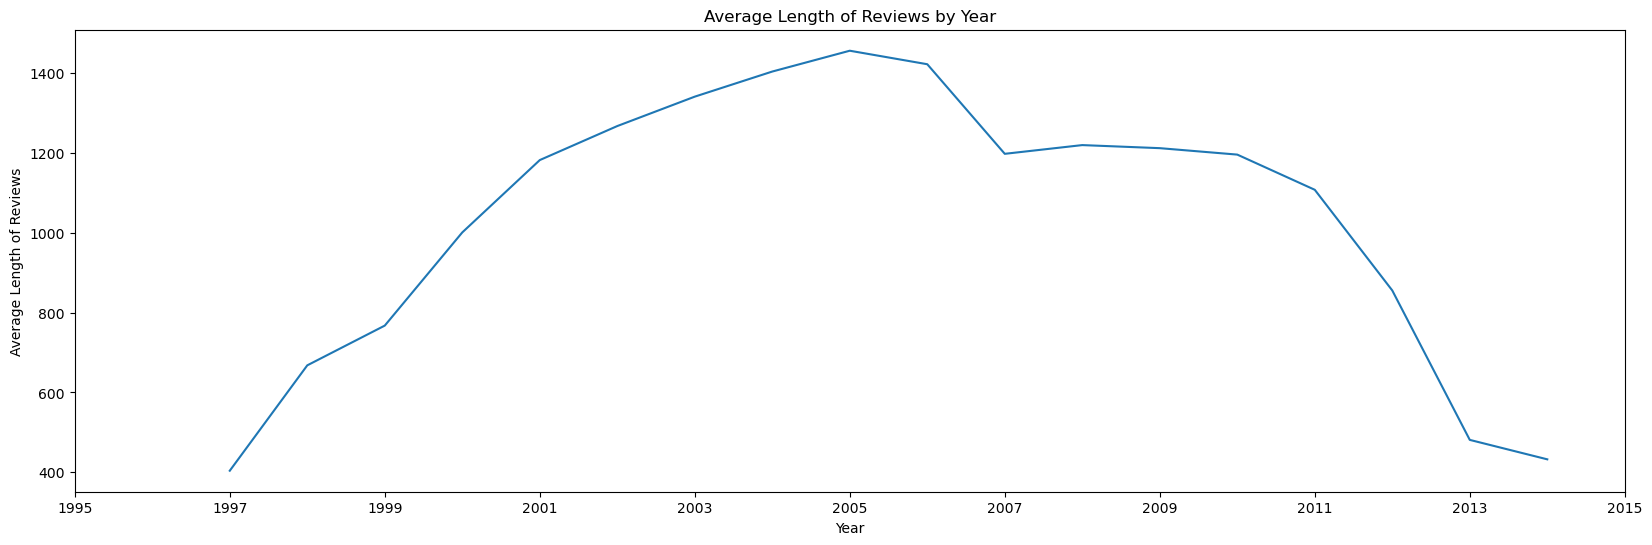

In [207]:
avg_length_by_year = movies_tv.groupby(movies_tv['year'])['reviewText'].apply(lambda x: x.str.len().mean()).reset_index()

sns.lineplot(data=avg_length_by_year, x='year', y='reviewText')
plt.title('Average Length of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Average Length of Reviews')
plt.xticks(ticks=range(1995, 2016, 2))
plt.show()

When we look at the graph "Histogram of Year" graph in question 1.1, we see that around 2012-2014 was when we had the most reviews. Here we see that the length of the reviews are very short around 2012-2014. This means that there were a lot of reviews but very short reviews. 

In contrast, 2005 had the least amount of reviews as seen in "Histogram of Year" in 1.1. This graph says that 2005 had the longest review length. This means that 2005 had the least reviews, but the reviews were long in length.

We also see a parabola shape of the length of the reviews over time.

#### 1.4 (10 marks)

We saw that movies and TV seem to have higher ratings in the 90s. Use a hypothesis test to determine if this is a statistically significant pattern. Specifically, 
- State the null and alternative hypotheses
- Run the appropriate hypothesis test in python
- Use the output to decide if you reject or fail to reject the null hypothesis 
- Interpret the p-value in this context 

The null hypothesis will always correspond to the hypothesis of no change; that is, the status quo is still valid. Formally, this is written as: $ H_0: \mu = \mu_0 $. Or in other words there is no change between the ratings from the before the 2000s to after the 2000s. 

The alternative hypothesis are:

1. $H_a: \mu \neq \mu_0$ (two-sided test)

2. $H_a: \mu > \mu_0$ (one-sided test)

3. $H_a: \mu < \mu_0$ (one-sided test)

In [208]:
ratings_90s = movies_tv[(movies_tv['year'] >= 1990) & (movies_tv['year'] < 2000)]['overall']
ratings_after_90s = movies_tv[movies_tv['year'] >= 2000]['overall']

print(stats.ttest_1samp(ratings_90s, ratings_after_90s.mean()))

TtestResult(statistic=-6.357189017605671, pvalue=2.1838453685581697e-10, df=7005)


In [209]:
print(stats.ttest_ind(ratings_90s, ratings_after_90s, equal_var=False))

TtestResult(statistic=-6.345201933070376, pvalue=2.358730348271699e-10, df=7058.083959688161)


In this class, we consider a p-value of less than 0.05 to be strong evidence against the null hypothesis. 

For _1samp:<br>
Here, our p-value is 2.18 * 10^-10, which is significantly less than our p-value. This is strong evidence against our null hypothesis - that there is no change between before the 2000s and after the 2000s for the average rating. We interpret this p-value as a security to reject the null hypothesis. However, this does not measure our level of security as accurate as using ttest_ind which compares the the sample of ratings before the 2000s and after the 2000s. Here there is a chance we compare a sample with values in ratings_90s, which is not what we want and not accurate. 

For _ind:<br>
Our p_value is 2.36 * 10^-10 which suggest even strong evidence against the null hypothesis. This is slight increase in p-value makes sense because we are sampling from ratings after the 90s with gurantee that we don't sample from ratings during the 90s. If we would to sample from ratings during the 90s it would "try" to favour the null hypothesis, decreasing our p-value ever so slightly. Since we can see from the graph in question 1.2 that the null hypothesis should be rejected, it makes sense why using _1samp gives a slightly higher p-value than using _ind - because it is less accurate with _1samp (also not the correct usage). 
 
We move on to favouring the alternate hypothesis, specifically, $H_a: \mu < \mu_0$ where $\mu$ is the average rating after the 2000s and $\mu_0$ is the average rating before the 2000s or $H_a: \mu > \mu_0$ if you swap the means around.

**Answer.** 

### Exercise 2 (10 marks): 

For the remainder of the assignment, we will use a smaller version of the `movies_tv` DataFrame given below:

In [210]:
short_movies_tv = movies_tv.head(10000)

Find the ten most frequently occurring non-stop words across: (i) all reviews, (ii) positive reviews (higher than 3 stars), (iii) (lower than 3 stars) negative reviews. 
Make a bar plot of the ten most frequently occurring words against their frequencies for each category ((i) (ii) and (iii)). What do you notice when comparing the graphs? Do the results surprise you? Why or why not? (A few bullet points is fine)

In [211]:
from collections import Counter
stop_words = stopwords.words('english')
stop_words.extend(["'s", '``', "''", "n't", '.', ',', ')', '(', ';', '!', '&', '?'])
# Learned .extend in EECS 1015, it merges the two lists together into stop words.

def most_frequent(reviews, k=10):
    reviews_clean = []
    sentences = nltk.sent_tokenize(reviews)
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        for word in words:
            if word.lower() not in stop_words:
                reviews_clean.append(word.lower())

    reviews_count = Counter(reviews_clean)
    return reviews_count.most_common(k)

all_reviews = short_movies_tv['reviewText']
all_reviews = ' '.join(all_reviews)

positive_reviews = short_movies_tv[short_movies_tv['overall'] > 3]['reviewText']
positive_reviews = ' '.join(positive_reviews)

negative_reviews = short_movies_tv[short_movies_tv['overall'] < 3]['reviewText']
negative_reviews = ' '.join(negative_reviews)   

common_all_reviews = most_frequent(all_reviews)
print(common_all_reviews)
# We see that "'s", '``', "''", and "n't" are in the top 10 most frequent words.
# These are not informative words, so we will add them to the stop words list. 
# We then get a bunch of punctiation that appear very frequently so we will also remove them.
common_pos_reviews = most_frequent(positive_reviews)
print(common_pos_reviews)
common_neg_reviews = most_frequent(negative_reviews)
print(common_neg_reviews) 
# We see that '?' appears often but it is not a non-stop word so we will omit it.
# With a count of 626, can interpret this as a customer having a lot of questions about the product.


[('movie', 13085), ('film', 10350), ('one', 7784), ('like', 4670), ('great', 4246), ('good', 4106), ('quot', 4106), ('story', 3579), ('would', 3570), ('time', 3356)]
[('movie', 10453), ('film', 8215), ('one', 6433), ('great', 3800), ('like', 3519), ('quot', 3331), ('good', 3212), ('story', 2933), ('time', 2771), ('would', 2569)]
[('movie', 1344), ('film', 1040), ('one', 654), ('like', 577), ('would', 530), ('jesus', 466), ('quot', 393), ('even', 348), ('see', 333), ('good', 332)]


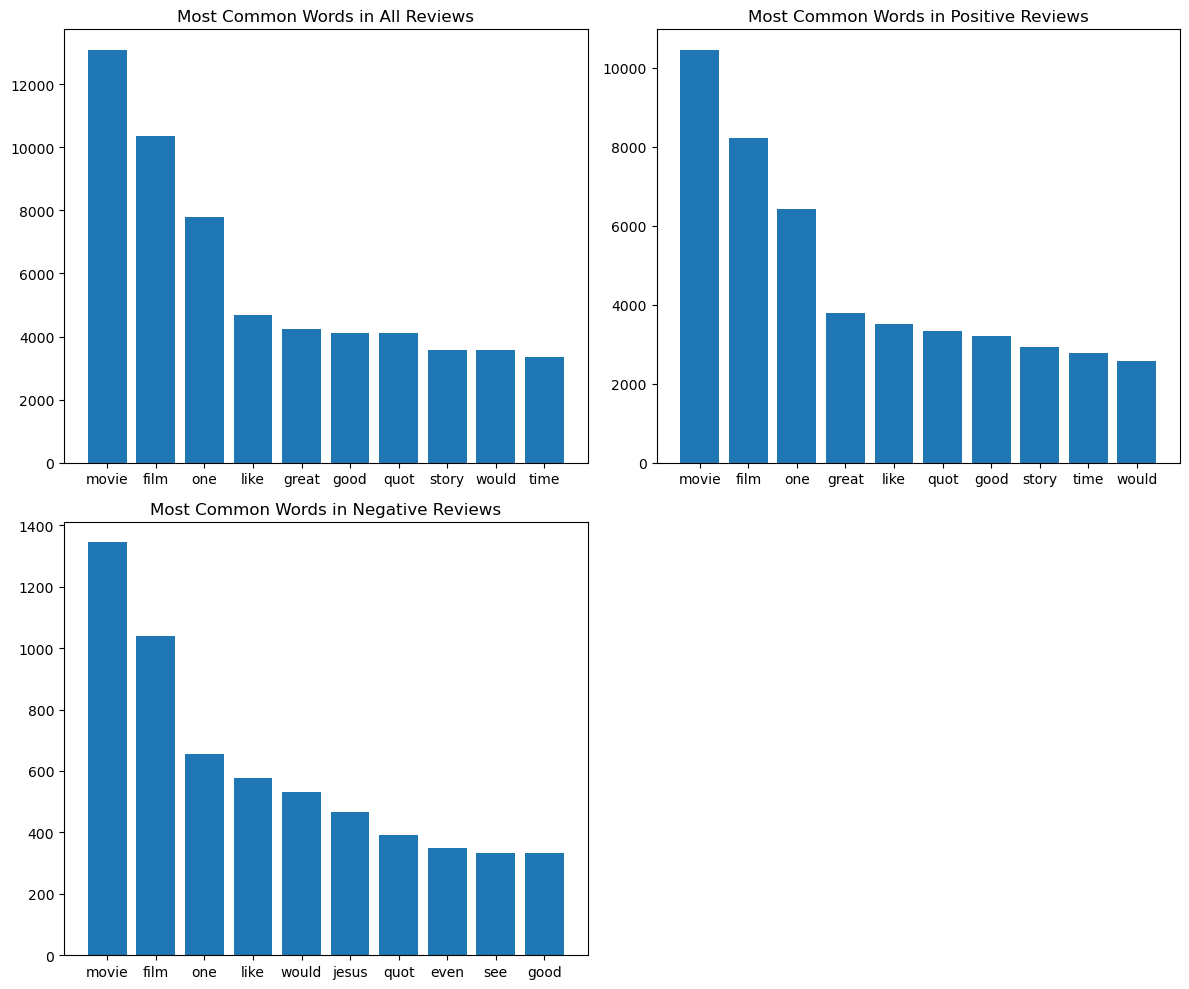

In [212]:
common_all_reviews_df = pd.DataFrame(common_all_reviews, columns = ['word', 'count'])
common_pos_reviews_df = pd.DataFrame(common_pos_reviews, columns = ['word', 'count'])
common_neg_reviews_df = pd.DataFrame(common_neg_reviews, columns = ['word', 'count'])
common_all_reviews_df

plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.bar(common_all_reviews_df['word'], common_all_reviews_df['count'])
plt.title('Most Common Words in All Reviews')
plt.xticks(rotation=0)

plt.subplot(2,2,2)
plt.bar(common_pos_reviews_df['word'], common_pos_reviews_df['count'])
plt.title('Most Common Words in Positive Reviews')
plt.xticks(rotation=0)

plt.subplot(2,2,3)
plt.bar(common_neg_reviews_df['word'], common_neg_reviews_df['count'])
plt.title('Most Common Words in Negative Reviews')
plt.xticks(rotation=0)

plt.tight_layout()


All Reviews:

We see that most frequent words are "movies" and "film" along with a lot of positive non-stop words such as "like", "good", and "great" although we do no know if "like" is used in the context of satisfaction or comparing something. The results of the top 10 did not surprise me because we are working with the movies_tv dataframe so we can expect movie or other words related to movie to appear very frequently. 

Positive Reviews (higher than 3 stars):

We see that the most frequent words are still 'movie' and 'film' which is expected because all the reviews also had 'movie' and 'film' has their top 2 most frequent word. We also see that the rest of the words in the positive reviews graph are in the all reviews graph. This means that the majority of reviews are good reviews which we can also confirm when we look at the frequency values of the positive graph and all reviews graph. We see that non-stop words excluding movies and film have a frequency near 4000 for the all reviews graph and around 3750 to 3000 for the positive reviews. So the majority of the all reviews graph is made up of the positive reviews.

Negative Reviews (lower than 3 stars):

We see that the words are similar to all reviews with some changes - "jesus", "even", and "see" appear in the top 10 most frequent words for bad reviews and "great", "story" and "time" are not present. This does not surprise me as this is expected since a bad review tyipcally discredits the product. In other words, a bad review mainly focuses on the cons of the product, rather than the overall product. As in we see more positive reviews mentioning the bad rather than bad reviews mentioning the good.

In general these plots are expected since we are dealing with a movies dataframe so it's expected to see "movies" appear frequently, positive words in positive review, and negative words in negative reviews.

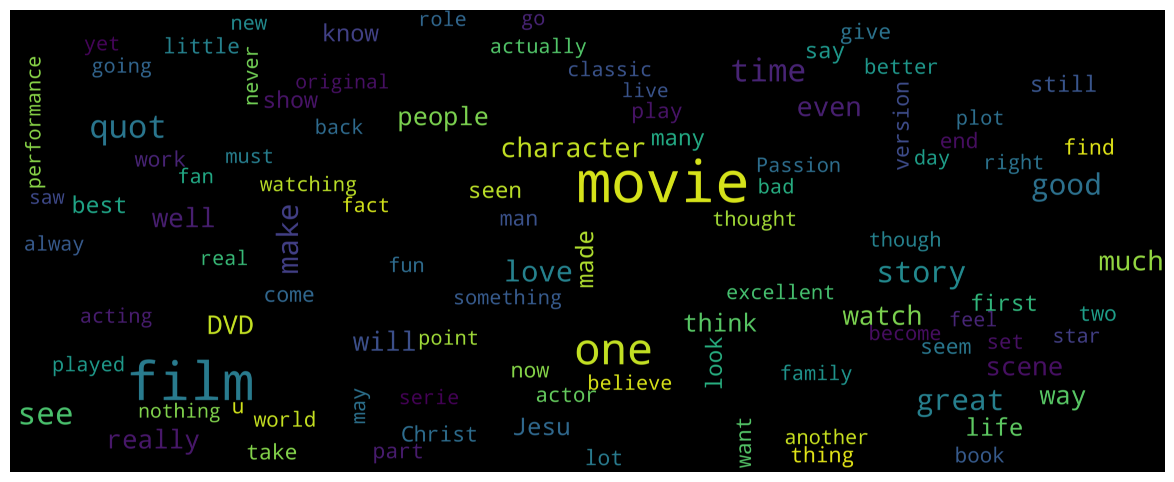

In [213]:
from wordcloud import WordCloud
from matplotlib import rcParams

word_cloud_text = ' '.join(short_movies_tv['reviewText'])
wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="black",
                          scale=10, width=2000, height=800).generate(word_cloud_text)
rcParams['figure.figsize'] = 20, 6
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Exercise 3 (8 marks):

Find 20 words that are indicative of bad reviews. That is, come up with a method to identify words that appear frequently in the bad reviews but do *not* occur frequently in the good reviews. What are these words? What do you observe about these words? Are they surprising?

In [214]:
stop_words = stopwords.words('english')
stop_words.extend(["'s", '``', "''", "n't", '.', ',', ')', '(', ';', '!', '&', '?'])
def most_frequent_all(reviews):
    reviews_clean = []
    sentences = nltk.sent_tokenize(reviews)
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        for word in words:
            if word.lower() not in stop_words:
                reviews_clean.append(word.lower())

    reviews_count = Counter(reviews_clean)
    return reviews_count.most_common()

pos_reviews_count = most_frequent_all(positive_reviews)
neg_reviews_count = most_frequent_all(negative_reviews)

In [215]:
neg_threshold = 6

pos_reviews_count_df = pd.DataFrame(pos_reviews_count, columns=['word', 'count'])
neg_reviews_count_df = pd.DataFrame(neg_reviews_count, columns=['word', 'count'])

pos_reviews_count_df = pos_reviews_count_df.rename(columns={'count': 'count_pos'})
neg_reviews_count_df = neg_reviews_count_df.rename(columns={'count': 'count_neg'})

pos_neg_df = pd.merge(pos_reviews_count_df, neg_reviews_count_df, on='word', how='outer')
pos_neg_df = pos_neg_df.fillna(0)
pos_neg_df['count_pos'] = pos_neg_df['count_pos'].astype(int)
pos_neg_df['count_neg'] = pos_neg_df['count_neg'].astype(int)
pos_neg_df['total'] = pos_neg_df['count_pos'] + pos_neg_df['count_neg']

pos_neg_df_clean = pos_neg_df[(pos_neg_df['count_neg'] > neg_threshold) & (pos_neg_df['count_pos'] > 0) ]
pos_neg_df_clean = pos_neg_df_clean.sort_values(by='count_neg', ascending=True).reset_index(drop=True)

pos_neg_df_clean.shape

(2079, 4)

In [216]:
pos_neg_df[pos_neg_df['count_neg'] > 0].describe() # mean is 5.3
# We will use 6 (round up) because this will make it more indicative of a negative word.

,count_pos,count_neg,total
count,15985.000000,15985.000000,15985.000000
mean,38.262559,5.278511,43.541070
std,182.835850,22.803413,204.506255
min,0.000000,1.000000,1.000000
25%,0.000000,1.000000,1.000000
50%,5.000000,1.000000,6.000000
75%,21.000000,3.000000,25.000000
max,10453.000000,1344.000000,11797.000000


,word,count_pos,count_neg,total,difference,order
0,redeeming,12,15,27,3,19
1,insulting,6,9,15,3,18
2,phony,4,7,11,3,17
3,charlotte,10,13,23,3,16
4,lundgren,4,7,11,3,15
5,beleive,3,7,10,4,14
6,bootleg,4,8,12,4,13
7,wee,6,10,16,4,12
8,usb,3,7,10,4,11
9,dolph,4,8,12,4,10


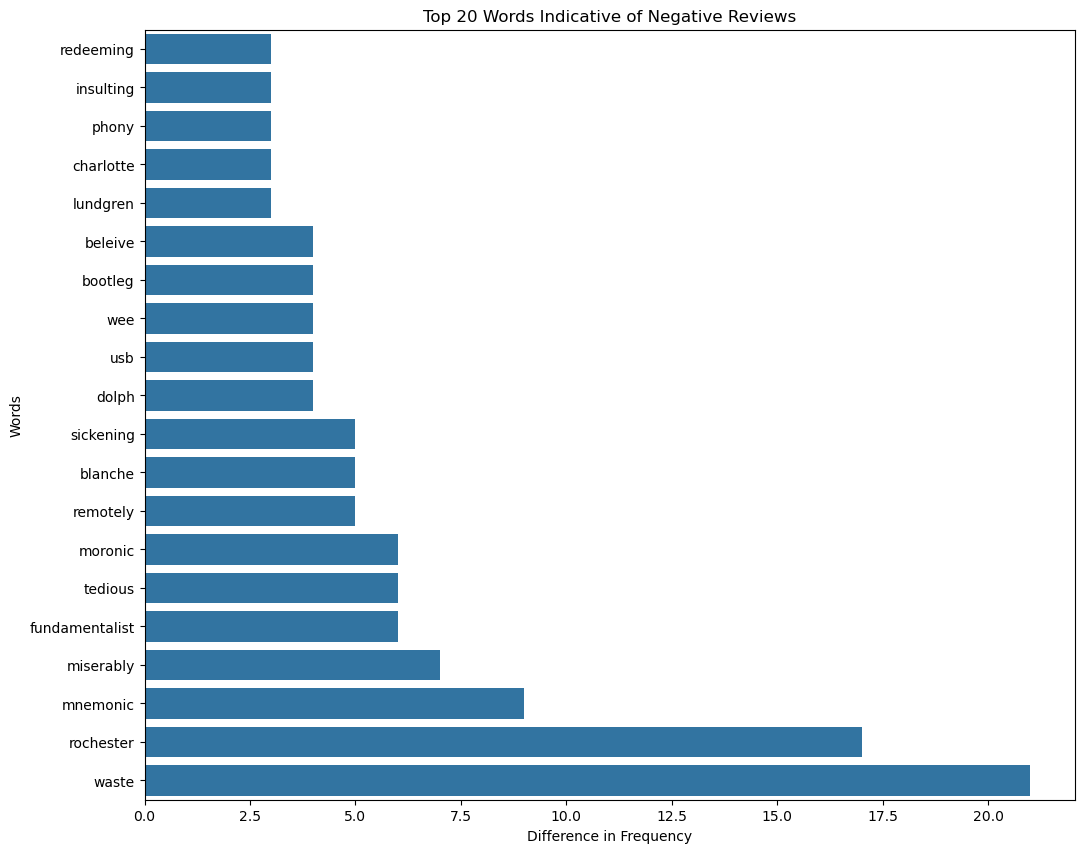

In [217]:
pos_neg_df_clean['difference'] = pos_neg_df_clean['count_neg'] - pos_neg_df_clean['count_pos']
top_20 = pos_neg_df_clean.sort_values(by='difference', ascending=False).head(20).reset_index(drop=True)
top_20['order'] = top_20.index
top_20 = top_20.sort_values(by='order', ascending=False).head(20).reset_index(drop=True)

plt.figure(figsize=(12,10))
sns.barplot(data=top_20, x='difference', y='word')
plt.xlabel('Difference in Frequency')
plt.ylabel('Words')
plt.title('Top 20 Words Indicative of Negative Reviews')
top_20

The 20 indicative words in bad reviews that do not occur frequently in positive reviews but do in negative are; waste, rochester, mnemonic, miserably, fundamentalist, tedious, moronic, remotely, blanche, sickening, dolph, usb, wee, bootleg, beleive, lundgren, charlotte, phony, insulting, and redeeming 

I observe that most of these words are negative words. This is not surprising because good reviews typcially do not contain negative words whereas negative reviews would more likely contain negative words. There are some neutral words (not negative or positive) such as usb and remotely. With context, it could be marked as a negative word. 

Words like usb and remotely are neutral and can take on negative or positive meanings depending on the context. For instance, if a usb drive causes issues while playing movies, it can be perceived negatively. Similarly, remotely can be used to emphasize negative expressions, such as "It is not remotely possible...," Words like phony, miserably moronic etc... are expected to be in this list as satistfied customers typcially would not use these words in their review.


Though Process: 
- Define a high frequency threshold for the counts of words in negative reviews. I chose to use the 75th quartile since the data has a very high standard deviation. 
- I did not define a low frequency threshold for the count for words in positive reviews since we can just use the negative frequency threshold to filter the dataframe then subtract the negative count by the positive count. The higher the difference, the more likely it is to appear in a negative review than positive review.
- We make sure to find the 75th quartile using `pos_neg_df[pos_neg_df['count_neg'] > 0].describe()` since a general describe will include words that only appear in positive reviews, thus, giving an inaccurate estimate of what a high frequency count is. 
- We make sure that the word also exists in the positive review when we do the division, since we are looking for words that appear frequently in the bad reviews but do *not* OCCUR frequently in the good reviews. This ensures that we are not left with words that only appear in negative reviews but both where there is a high count in the negative reviews and low count in the positive reviews.

**Answer.**

### Exercise 4 (8 marks): 

Use the following code to inspect the first 50 1-star reviews from the `movies_tv` DataFrame containing the word "good". Discuss the most common ways the word good is used in these reviews. Are any of these informative or challenging for our analysis of what drives very negative reviews? 

In [218]:
v_bad_indices = movies_tv['overall'] < 1.1
v_bad_reviews = movies_tv[v_bad_indices]

RED_START = "\033[91m"
END = "\033[0m"

good_word_bad_review = [rev for rev in v_bad_reviews['reviewText'] if 'good' in rev.lower()]

print(len(good_word_bad_review))
for rev in good_word_bad_review[:50]:
    good_i = rev.lower().index("good")
    # we add Ansi codes to highlight the matches
    print(rev[good_i-50: good_i] + RED_START + rev[good_i:good_i+4] + END + rev[good_i+4:good_i +50])

27680
good, the story was correct, but naked backsides w
good but the scene with Yukon discovering peppermi
th absolutely NO edits whatsoever to the material.Good for us!Edits are for losers!I have spoken.
t least made it about an interesting story with a good plot and character development...i agree with
t everything I've seen thus far does not resemble good cinema in any shape, form, or manner. So, I g
itself is beautifully filmed. The acting is quite good and as a history freak I found it interesting
rtaining) and provides nothing that makes us feel good or is uplifting or is of any benefit, except 
ven if that person is Christ. The flashbacks were good and I'd rather have watched them than watched
to explain what singled out Christ as a symbol of good because a)he is a shallow and poor filmmaker 
 (and no-one could endure the pain).They say it's good to show the extent of the sacrifice that Jesu
good review when it was released, and I went to se
 story that everyone knows and of co

"Good" can be used to praise small details in a movie or as harsh sarcasm to point out how bad it is. For example, "If you enjoyed this movie, there is a good chance you have an undiagnosed mental illness" uses "good" sarcastically to make fun of the movie.

While some of these reviews are harsh, some can be used to help the business make improvements. For example: "so at least I could have enjoyed good music. By the way, The Passion's music sucks" will let the producers know that the music is generally good, with only Passion's music needing improvements. Some of these reviews also follow the word "good" with "but" which can indicate potential reasons why people rated it 1 stars. For example: "good, the story was correct, but naked backsides w" and "good but the scene with Yukon discovering peppermi."  This is informative as there might be a lot of children who watch the movies so the exessive naked backsides may be driving the negative reviews. The scene with Yukon discovering what seems to be peppermint should be analysed more thoroughly to understand why many did not enjoy that scene.

All in all, these reviews are informative to our analysis of what drives negative reviews. While some of these are bashing the movies, some provide why they gave it 1 stars as well as giving feedback on what they enjoyed.

**Answer.**

### Exercise 5 (15 marks): 

For each review in the list of bad reviews containing the word "good" that we found in the last question (`good_word_bad_review`) extract the following:

1. The first word after "good"
2. The first word after "good" that is a noun or cardinal
3. The last word before "good" that is a noun or cardinal

For example, "The popcorn at the movie was very good with butter." would have the solution

1. with
2. butter
3. movie

Print out the results for the first 15 reviews in the list `good_word_bad_review`. 

In [219]:
nltk.download('averaged_perceptron_tagger')

# for rev in good_word_bad_review[:50]:
#     text_word_token = nltk.word_tokenize(rev)
#     pos_tags = nltk.pos_tag(text_word_token)
#     print(text_word_token)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fabie\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [232]:
def get_first_after_good(rev):
    rev = rev.lower()
    text_word_token = nltk.word_tokenize(rev)
    if 'good' in text_word_token:
        good_index = text_word_token.index('good')
        return text_word_token[good_index + 1]

# The first word after "good" that is a noun or cardinal
def get_first_after_nn_cd(rev):
    rev = rev.lower()
    text_word_token = nltk.word_tokenize(rev)
    pos_tags = nltk.pos_tag(text_word_token)
    if 'good' in text_word_token:
        good_index = text_word_token.index('good')
        for word, tag in pos_tags[good_index + 1:]:
            if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'CD']:
                return word
    return "Not found / NA"

# The last word before "good" that is a noun or cardinal
def get_last_before_nn_cd(rev):
    rev = rev.lower()
    text_word_token = nltk.word_tokenize(rev)
    pos_tags = nltk.pos_tag(text_word_token)
    if 'good' in text_word_token:
        good_index = text_word_token.index('good')
        for word, tag in reversed(pos_tags[:good_index]):
            if tag in ['NN', 'NNS', 'NNP', 'NNPS', 'CD']:
                return word
    return "Not found / NA"


# Have to print it out 5 at a time because it displays some then shows "..." for the rest
for rev in good_word_bad_review[:5]:
    first_word_after_good = get_first_after_good(rev)
    first_nn_or_cd_after_good = get_first_after_nn_cd(rev)
    last_nn_or_cd_before_good = get_last_before_nn_cd(rev)
    # print(f'Review: {rev}')
    print(f'First word after "good": {first_word_after_good}')
    print(f'First noun or cardinal after "good": {first_nn_or_cd_after_good}')
    print(f'Last noun or cardinal before "good": {last_nn_or_cd_before_good}')
    print()

First word after "good": ,
First noun or cardinal after "good": story
Last noun or cardinal before "good": acting

First word after "good": but
First noun or cardinal after "good": scene
Last noun or cardinal before "good": transfer

First word after "good": None
First noun or cardinal after "good": Not found / NA
Last noun or cardinal before "good": Not found / NA

First word after "good": plot
First noun or cardinal after "good": plot
Last noun or cardinal before "good": story

First word after "good": cinema
First noun or cardinal after "good": cinema
Last noun or cardinal before "good": i



In [229]:
for rev in good_word_bad_review[6:11]:
    first_word_after_good = get_first_after_good(rev)
    first_nn_or_cd_after_good = get_first_after_nn_cd(rev)
    last_nn_or_cd_before_good = get_last_before_nn_cd(rev)
    # print(f'Review: {rev}')
    print(f'First word after "good": {first_word_after_good}')
    print(f'First noun or cardinal after "good": {first_nn_or_cd_after_good}')
    print(f'Last noun or cardinal before "good": {last_nn_or_cd_before_good}')
    print()

First word after "good": or
First noun or cardinal after "good": benefit
Last noun or cardinal before "good": nothing

First word after "good": and
First noun or cardinal after "good": scenes.to
Last noun or cardinal before "good": flashbacks

First word after "good": because
First noun or cardinal after "good": filmmaker
Last noun or cardinal before "good": symbol

First word after "good": to
First noun or cardinal after "good": extent
Last noun or cardinal before "good": pain

First word after "good": review
First noun or cardinal after "good": review
Last noun or cardinal before "good": film



In [228]:
for rev in good_word_bad_review[11:16]:
    first_word_after_good = get_first_after_good(rev)
    first_nn_or_cd_after_good = get_first_after_nn_cd(rev)
    last_nn_or_cd_before_good = get_last_before_nn_cd(rev)
    # print(f'Review: {rev}')
    print(f'First word after "good": {first_word_after_good}')
    print(f'First noun or cardinal after "good": {first_nn_or_cd_after_good}')
    print(f'Last noun or cardinal before "good": {last_nn_or_cd_before_good}')
    print()

First word after "good": and
First noun or cardinal after "good": lots
Last noun or cardinal before "good": corse

First word after "good": film
First noun or cardinal after "good": film
Last noun or cardinal before "good": anguish

First word after "good": music
First noun or cardinal after "good": music
Last noun or cardinal before "good": i

First word after "good": grief
First noun or cardinal after "good": grief
Last noun or cardinal before "good": Not found / NA

First word after "good": box
First noun or cardinal after "good": box
Last noun or cardinal before "good": friend



**Answer.** 

### Exercise 6 (20 marks):

We have seen that individual words are not always very informative. Find the 20 most often occurring bigrams and trigrams in the (i) positive and (ii) negative reviews. Visualize the most frequently occurring bigrams and trigrams in (i) and (ii) and give a brief analysis of the n-grams you identified.

In [223]:
from nltk.util import ngrams

def top_k_ngrams(word_tokens, n):
    word_tokens = [word.lower() for word in word_tokens]
    word_tokens = [word for word in word_tokens if word not in stop_words and len(word) > 2]
    ngrams_l = list(ngrams(word_tokens, n))
    counted = Counter(ngrams_l)
    mc = counted.most_common(20)
    return mc

word_tokens_pos = nltk.word_tokenize(positive_reviews)
word_tokens_neg = nltk.word_tokenize(negative_reviews)

bigrams_pos = pd.DataFrame(top_k_ngrams(word_tokens_pos, 2), columns=['bigram', 'count'])
trigrams_pos = pd.DataFrame(top_k_ngrams(word_tokens_pos, 3), columns=['trigram', 'count'])
bigrams_neg = pd.DataFrame(top_k_ngrams(word_tokens_neg, 2), columns=['bigram', 'count'])
trigrams_neg = pd.DataFrame(top_k_ngrams(word_tokens_neg, 3), columns=['trigram', 'count'])

bigrams_pos['bigram'] = bigrams_pos['bigram'].apply(lambda x: ' '.join(x))
trigrams_pos['trigram'] = trigrams_pos['trigram'].apply(lambda x: ' '.join(x))
bigrams_neg['bigram'] = bigrams_neg['bigram'].apply(lambda x: ' '.join(x))
trigrams_neg['trigram'] = trigrams_neg['trigram'].apply(lambda x: ' '.join(x))

trigrams_neg

,trigram,count
0,last temptation christ,12
1,air force one,9
2,gibson passion christ,8
3,'ve ever seen,8
4,movies ever seen,7
5,dolby digital 5.1,7
6,blu ray player,7
7,quot starship troopers,7
8,starship troopers quot,7
9,one worst movies,6


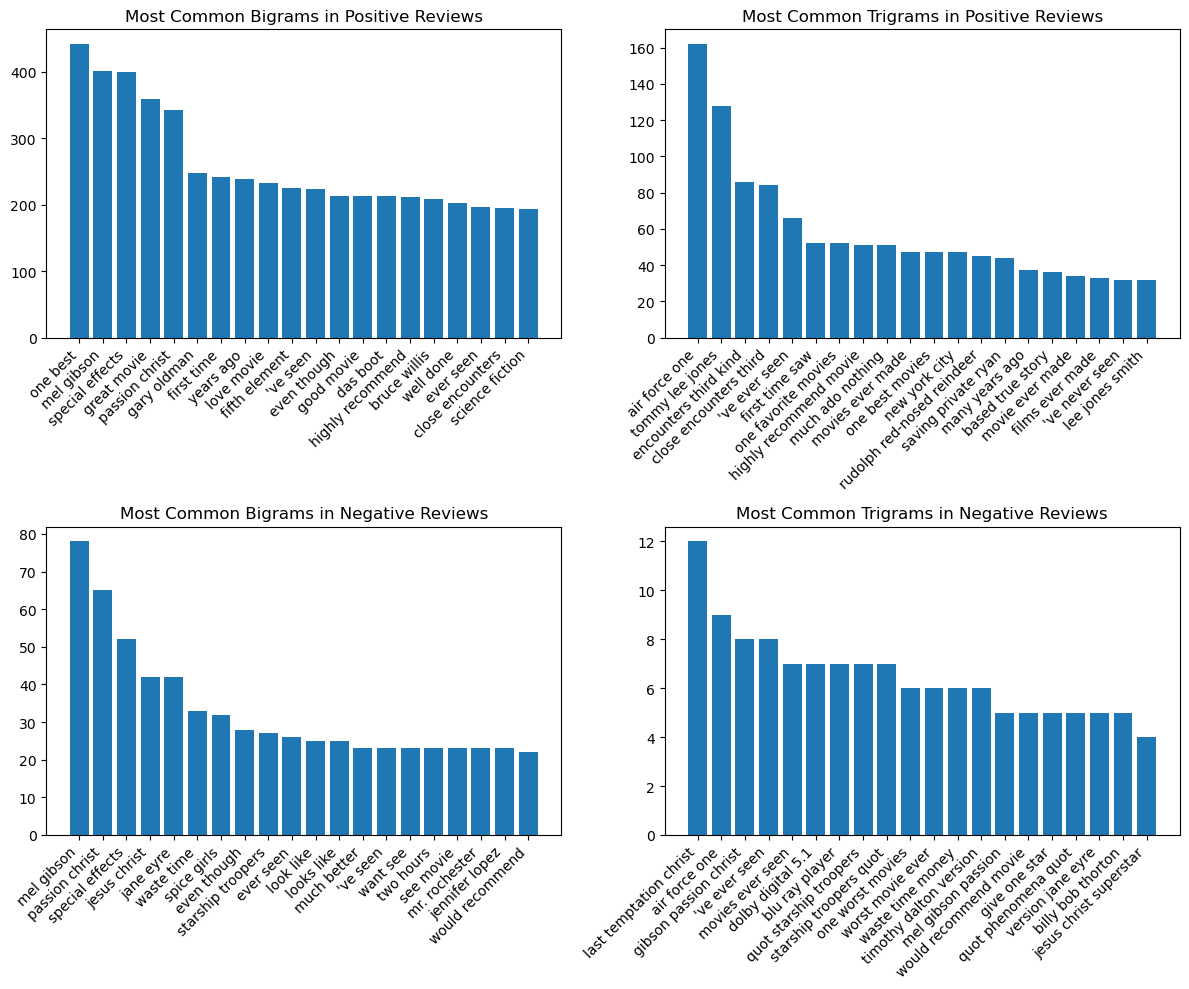

In [224]:
plt.figure(figsize=(12,10))

plt.subplot(2,2,1)
plt.bar(bigrams_pos['bigram'], bigrams_pos['count'])
plt.title('Most Common Bigrams in Positive Reviews')
plt.xticks(rotation=45, ha='right')
# Source for ha="right": https://stackoverflow.com/questions/22664091/matplotlib-text-alignment

plt.subplot(2,2,2)
plt.bar(trigrams_pos['trigram'], trigrams_pos['count'])
plt.title('Most Common Trigrams in Positive Reviews')
plt.xticks(rotation=45, ha='right')

plt.subplot(2,2,3)
plt.bar(bigrams_neg['bigram'], bigrams_neg['count'])
plt.title('Most Common Bigrams in Negative Reviews')
plt.xticks(rotation=45, ha='right')

plt.subplot(2,2,4)
plt.bar(trigrams_neg['trigram'], trigrams_neg['count'])
plt.title('Most Common Trigrams in Negative Reviews')
plt.xticks(rotation=45, ha='right')


plt.tight_layout()

We see that "mel gibson" appears for the most common bigrams in positive and negative. Assuming this is a character in the movie, this character may be a hit or miss for some. We also see that "air force one" is common amongst the common trigrams in positive and negative reviews which means that this could also be a hit or miss for some. 

In the positive bigram and trigram, we see more words complimenting the movie such as "highly recommend", "well done" "one best" which could be "one of the best" since we removed the stop words. We see that really positive words in the review.

In the negative bigram and trigram, we see more negative words as well as name (or atleast what is appears to be). It expresses its negative feelings towards the movie with words like "waste time", "worst movie ever", and "give one star." The names which appear very often in the bigrams and trigrams may be characters which the audience dislike, perhaps becaus of their acting skills or contribution to the plot of the movie.

For the most part, the words in the positive bigrams and trigrams are more related than the words in the negative bigrams and trigrams. This also could be because there are significantly more positive reviews than negative reviews.

**Answer.** 

### Exercise 7 (8 marks): 

Throughout the above search for informative words, we have seen that unigrams are not enough, but important words (such as "good") are not always next to the informative words that they describe. Devise a method to extract these informative words. Provide a brief description of how you will extract the informative words. (You do not need to implement your method.)

Instead of using unigrams, we will apply a similar principle but focus on nouns and adjectives. We will mark nouns and adjectives as important words and for each important word, we take 3 words before and 3 words (could be more or less 3 words) after the important word. We then use the Counter function to count and see which words most often appear with nouns and adjectives. We also make sure to remove the stop words as stop words are not informative. This approach helps capture the context and relationships between the important words like nouns and adjectives, providing a more comprehensive understanding of the text.

**Answer.**

### Exercise 8 (9 marks): 

Write a function(s) that transforms a document into a list of adjective-noun pairs. 
- For each sentence in the document, find each adjective in the sentence and find the first noun that follows it in the sentence. Combine the adjective with the noun in a string that has the format "adjective noun". 
- For example, the document "That was a good, long movie" should return `["good movie", "long movie"]`. If no nouns appear after an adjective, do not add that adjective to the output list. 
- Demonstrate your function works on the first review in `short_movies_tv` and the sentence "The big black dog scared the red cat."

In [225]:
# Source for all adjective tags (i couldnt find in case 10)
# https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/ 

def adjective_noun_pair(sentence):
    sentence = sentence.lower()
    text_word_token = nltk.word_tokenize(sentence)
    pos_tags = nltk.pos_tag(text_word_token)
    adj_noun_pairs = []
    for pair_idx, (word, tag) in enumerate(pos_tags):
        if tag in ['JJ', 'JJR', 'JJS']:
            for pairs_after_adj_idx in range(pair_idx+1, len(pos_tags)):
                if pos_tags[pairs_after_adj_idx][1] in ['NN', 'NNS', 'NNP', 'NNPS']:
                    adj_noun_pairs.append((word, pos_tags[pairs_after_adj_idx][0]))
                    # break statement makes sure we only assign the first noun and not all nouns following the adjective
                    break
    print(sentence)
    print(pos_tags)
    return adj_noun_pairs

adjective_noun_pair("The big black dog scared the red cat")

the big black dog scared the red cat
[('the', 'DT'), ('big', 'JJ'), ('black', 'JJ'), ('dog', 'NN'), ('scared', 'VBD'), ('the', 'DT'), ('red', 'JJ'), ('cat', 'NN')]


[('big', 'dog'), ('black', 'dog'), ('red', 'cat')]

In [226]:
adjective_noun_pair(short_movies_tv['reviewText'][0])

this is a charming version of the classic dicken's tale.  henry winkler makes a good showing as the "scrooge" character.  even though you know what will happen this version has enough of a change to make it better that average.  if you love a christmas carol in any version, then you will love this.
[('this', 'DT'), ('is', 'VBZ'), ('a', 'DT'), ('charming', 'JJ'), ('version', 'NN'), ('of', 'IN'), ('the', 'DT'), ('classic', 'JJ'), ('dicken', 'NN'), ("'s", 'POS'), ('tale', 'NN'), ('.', '.'), ('henry', 'NN'), ('winkler', 'NN'), ('makes', 'VBZ'), ('a', 'DT'), ('good', 'JJ'), ('showing', 'NN'), ('as', 'IN'), ('the', 'DT'), ('``', '``'), ('scrooge', 'NN'), ("''", "''"), ('character', 'NN'), ('.', '.'), ('even', 'RB'), ('though', 'IN'), ('you', 'PRP'), ('know', 'VBP'), ('what', 'WP'), ('will', 'MD'), ('happen', 'VB'), ('this', 'DT'), ('version', 'NN'), ('has', 'VBZ'), ('enough', 'VBN'), ('of', 'IN'), ('a', 'DT'), ('change', 'NN'), ('to', 'TO'), ('make', 'VB'), ('it', 'PRP'), ('better', 'JJR'), 

[('charming', 'version'),
 ('classic', 'dicken'),
 ('good', 'showing'),
 ('better', 'average')]

**Answer.** 